# Classificador de Sentimentos

O seguinte código tem como objetivo analisar uma base de dados do IMDB para identificar o sentimento daquela base de dados a partir da resenha escrita, tendo como negativa ou positiva.
Vamos criar um analisador de sentimentos, ou seja, um modelo de Machine Learning capaz de analisar um determinado texto e classificá-lo de acordo com o sentimento, se a pessoa gostou ou não do texto. Para isso utilizaremos uma base de dados do IMDb (Internet Movie Database), uma plataforma que reúne dados de filmes, programas, comerciais, música e até de jogos.
Os dados podem ser acessados pelo seguinte Link: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr

## Importando e Visualizando os Dados

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 8.6 MB/s eta 0:00:00


In [ ]:
# bibliotecas a serem utilizadas
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk import tokenize
from string import punctuation
from nltk import ngrams

nltk.download("stopwords")
nltk.download('rslp')

import unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
df = pd.read_csv('/content/imdb-reviews-pt-br.csv')
df.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [ ]:
# verificando os dados
print(df['text_pt'].iloc[100])

Imagine cada clichê estereotipado e exagerado de todos os filmes e programas de TV nas ruas de Brooklyn entre 1930 e 1980. Preencha-o com um elenco de caricaturas intercambiáveis ​​em vez de personagens reais. Acrescente uma mistura de músicas de "período" e guitarras elétricas lamentáveis ​​durante as cenas "estrondosas". Em seguida, passe o tempo tentando descobrir ou importar qual dos Deuces vai ser morto no estrondo final anticlímax.Eu vou dar este filme aponta para não ser apenas mais uma comédia romântica, teen slasher, filme de ação explosivo, comédia de sexo adolescente, infantil musical, ou veículo de indicação ao Oscar. Mas trazer algo novo ou interessante para o gênero da tragédia das gangues de rua pode ter sido bom.


## Transformando os Dados

Aqui vamos fazer algumas alterações em nossos dados, no caso colocar os rótulos como números, vetorizar e colocar em uma matriz esparsa. Porém vamos limitar essa vetorização devido ao poder computacional que uma grande vetorização pode exigir. Sem mais delongas, vamos lá!

In [ ]:
df['classe'] = df['sentiment'].replace(['neg', 'pos'], [0, 1])
df.head()

In [ ]:
vetor = CountVectorizer(lowercase=False, max_features=50) # o max_features, seleciona as 50 palavras "mais importantes"
bag_of_words = vetor.fit_transform(df['text_pt'])
bag_of_words.shape # verificando a vetorização

(49459, 50)

## Criando um Modelo Base

Aqui vamos criar uma modelo base, aquele que queremos ultrapassar e para ultrapassar esse modelo base vamos usar features mas isso vai ficar para o próximo tópico, aqui vamos apenas separar nossos dados "sujos" e treinar eles.

In [ ]:
# separando os dados
treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, df['classe'], stratify=df['classe'], random_state=42)

In [ ]:
# usando uma regressão logistica
reg_log = LogisticRegression()
reg_log.fit(treino, classe_treino)

acc = reg_log.score(teste, classe_teste)
print(acc)

0.6507076425394258


In [ ]:
# função de classificação
def classif_text(df, coluna_texto, coluna_classe):
  vetor = CountVectorizer(lowercase=False, max_features=50) 
  bag_of_words = vetor.fit_transform(df[coluna_texto])

  treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, df[coluna_classe], stratify=df['classe'], random_state=42)

  reg_log = LogisticRegression()
  reg_log.fit(treino, classe_treino)
  return reg_log.score(teste, classe_teste)

In [ ]:
# validando a função
classif_text(df, 'text_pt', 'classe')

0.6507076425394258

## Explorando os Dados

Aqui vamos fazer uma série de exploração com o intuito de visualizar e procurar meios de melhorar o nosso modelo, a fim de que ele possa classificar de forma correta os sentimentos.

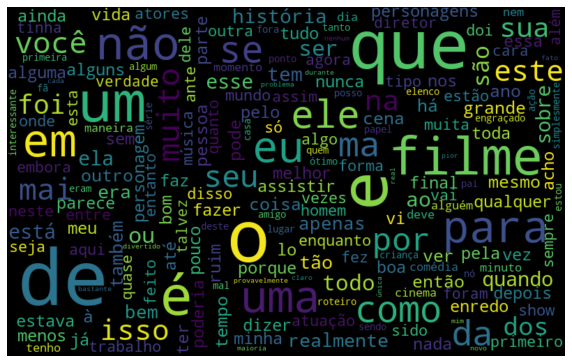

In [ ]:
# preparando as palavras
palavras = ''.join([texto for texto in df['text_pt']]) # pegando todas as palavras
word_cloud = WordCloud(width=800, height=500, max_font_size= 110,
                       collocations=False).generate(palavras)
# plotando a nuvem de palavras
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Aqui está apenas às palavras, pois removemos os bigramas, entretanto ainda se mantém palavras como "de, ele, que" o que não dá tanta informação. Para uma melhora, vamos fazer palavras que remetem a sentimentos negativos e a positivos.

In [ ]:
def cloud_neg(df, coluna_texto):
  texto_neg = df.query('classe == 0')
  palavras = ''.join([texto for texto in texto_neg['text_pt']]) 
  word_cloud = WordCloud(width=800, height=500, max_font_size= 110, collocations=False).generate(palavras)
  plt.figure(figsize=(10,7))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [ ]:
def cloud_pos(df, coluna_texto):
  texto_pos = df.query('classe == 1')
  palavras = ''.join([texto for texto in texto_pos['text_pt']]) 
  word_cloud = WordCloud(width=800, height=500, max_font_size= 110, collocations=False).generate(palavras)
  plt.figure(figsize=(10,7))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

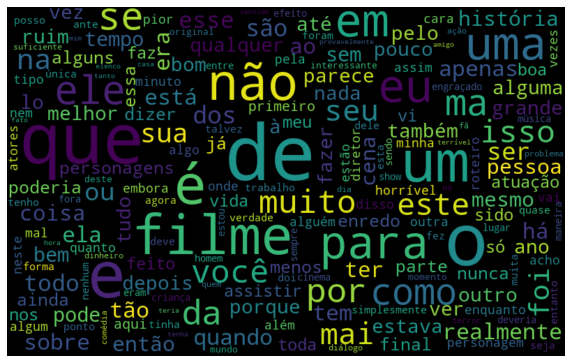

In [ ]:
cloud_neg(df, 'text_pt')

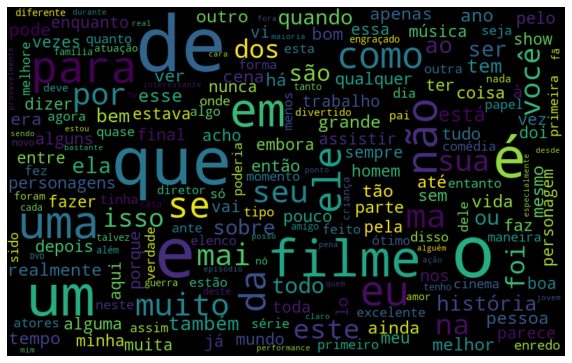

In [ ]:
cloud_pos(df, 'text_pt')

### Aplicando NLTK

Aqui vamos fazer o uso da biblioteca NLTK e explorar mais um pouco nossos dados, com o mesmo intuito de buscar a limpeza necessária para o nosso modelo.

In [ ]:
# aplicadno o nltk
palavras = ''.join([texto for texto in df['text_pt']])

token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(palavras)
freq = nltk.FreqDist(token_frase)

df_freq = pd.DataFrame({'Palavra': list(freq.keys()), 'Frequência': list(freq.values())})
df_freq.head()

,Palavra,Frequência
0,Mais,1469
1,uma,130883
2,"vez,",1927
3,o,244836
4,Sr.,1738


In [ ]:
# 10 itens que mais se repete
df_freq.nlargest(columns='Frequência', n=10)

,Palavra,Frequência
20,de,417383
14,que,325058
42,e,299720
3,o,244836
7,um,216380
102,a,210154
45,é,192359
199,em,132770
1,uma,130883
29,não,127894


Um fato a se observar aqui é que essas palavras que mais se repetem não me agregam muito na análise, o que não me permite fazer uma análise mais detalhada, uma opção para solucionar isso é a exclusão desta, mas antes disso vamos fazer uma visualização gráfica. 



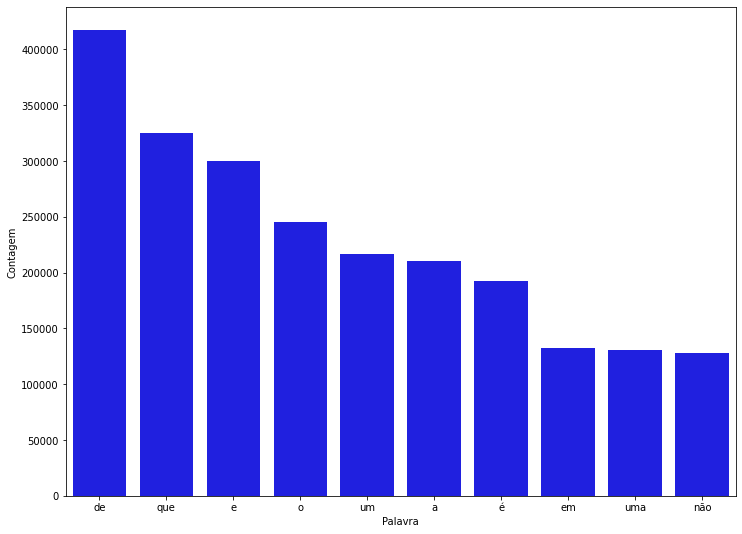

In [ ]:
plt.figure(figsize=(12,9))
ax = sns.barplot(data=df_freq.nlargest(columns='Frequência', n=10), x='Palavra', y='Frequência', color='blue')
ax.set(ylabel='Contagem')
plt.show() 

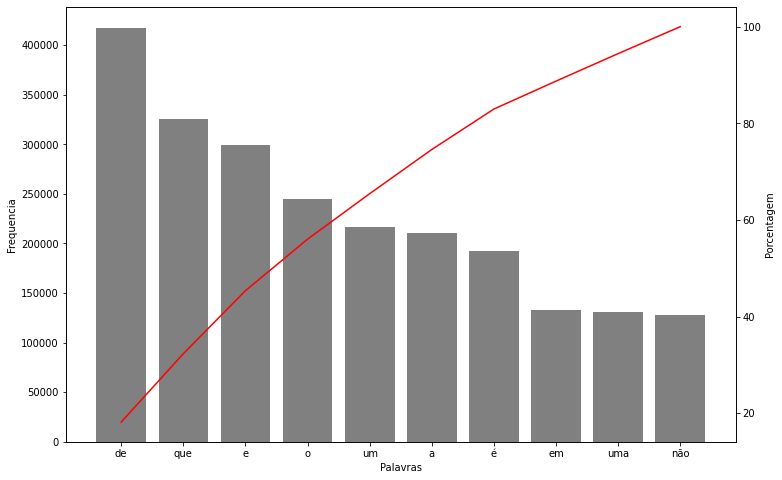

In [ ]:
def pareto_real(df, coluna_texto, quantidade):
  palavras = ' '.join([resenha for resenha in df[coluna_texto]])
  token_espaco = nltk.tokenize.WhitespaceTokenizer()
  token_frase = token_espaco.tokenize(palavras)
  freq = nltk.FreqDist(token_frase)
  df_freq = pd.DataFrame({'Palavras': list(freq.keys()),
                               'Frequencia': list(freq.values())})
  df_freq = df_freq.nlargest(n=quantidade, columns='Frequencia')

  total = df_freq['Frequencia'].sum() 
  df_freq['Porcentagem'] = df_freq['Frequencia'].cumsum() / total * 100 # pegando a porcentagem de cada palavra

  plt.figure(figsize=(12,8))
  ax = sns.barplot(data=df_freq, x='Palavras', y='Frequencia', color='gray')
  ax2 = ax.twinx() # criação do eixo secundário
  sns.lineplot(data=df_freq, x='Palavras', y='Porcentagem', color='red', sort=False, ax=ax2) # plotando a linha de parteo
  plt.show()

pareto_real(df, 'text_pt', 10)

## Tratando os Dados

Agora vamos começar o nosso tratamento, removendo palavras que não agrega, deixando tudo em minúsculo, removendo pontuações, acentos, etc.

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
palavras_irr = nltk.corpus.stopwords.words("portuguese")
frase_proc = []

# script para remoção dos stop words
for opiniao in df['text_pt']:
  nova_frase = []
  palavras_texto = token_espaco.tokenize(opiniao) # separando palavra por palavra
  for palavra in palavras_texto:
    if palavra not in palavras_irr: # caso nossa palavra não esteja nas stop words
      nova_frase.append(palavra)
  frase_proc.append(' '.join(nova_frase)) # juntando todas as palavras

df['tratamento_1'] = frase_proc 
df.head()

,id,text_en,text_pt,sentiment,classe,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


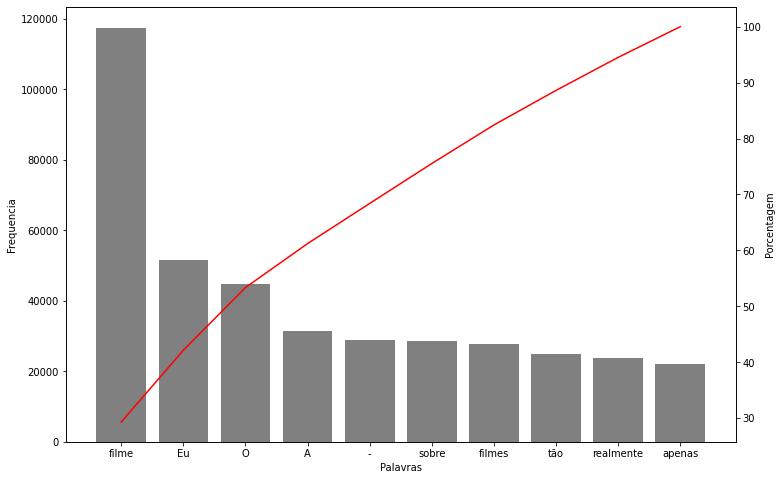

In [ ]:
pareto_real(df, 'tratamento_1', 10)

### Removendo Pontuações

Aqui vamos remover pontuação para evitar que palavras iguais sejam declaradas como diferentes devido a pontuação. Um exemplo disso é:

* perfeito,

* perfeito.

* perfeito

Observa que essas 3 palavras são a mesma, mas devido a pontuação vai ocorrer uma diferença entre elas.

In [ ]:
token_pontuacao = tokenize.WordPunctTokenizer()

pontuacao = []
for ponto in punctuation: # punctation foi a biblioteca chamda lá em cima
  pontuacao.append(ponto) # criando a pontuação em uma lista, sendo cada pontuação um item da lista

pontuacao_stop_words = pontuacao + palavras_irr 
frase_proc = []
for opiniao in df['tratamento_1']:
  nova_frase = []
  palavra_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavra_texto:
    if palavra not in pontuacao_stop_words:
      nova_frase.append(palavra)
  frase_proc.append(' '.join(nova_frase))

df['tratamento_2'] = frase_proc

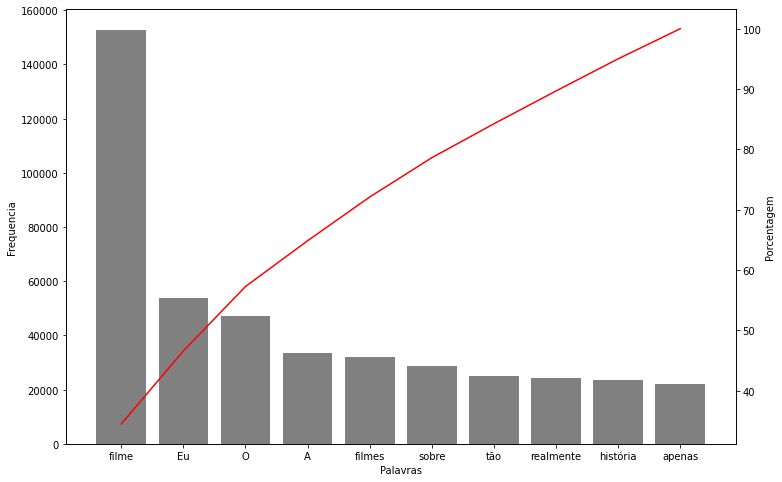

In [ ]:
pareto_real(df, 'tratamento_2', 10)

### Removendo Acentos

In [ ]:
sem_acentos = [unidecode.unidecode(texto) for texto in df['tratamento_2']]

In [ ]:
# aplicando em nosso conjunto de dados
sem_acentos = [unidecode.unidecode(texto) for texto in df['tratamento_2']]

# removendo acentosdo stop words
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stop_words]

In [ ]:
df['tratamento_3'] = sem_acentos

frase_processada = []
for opiniao in df['tratamento_3']:
  nova_frase = []
  palavra_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavra_texto:
    if palavra not in stopwords_sem_acento:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))

df['tratamento_3'] = frase_processada

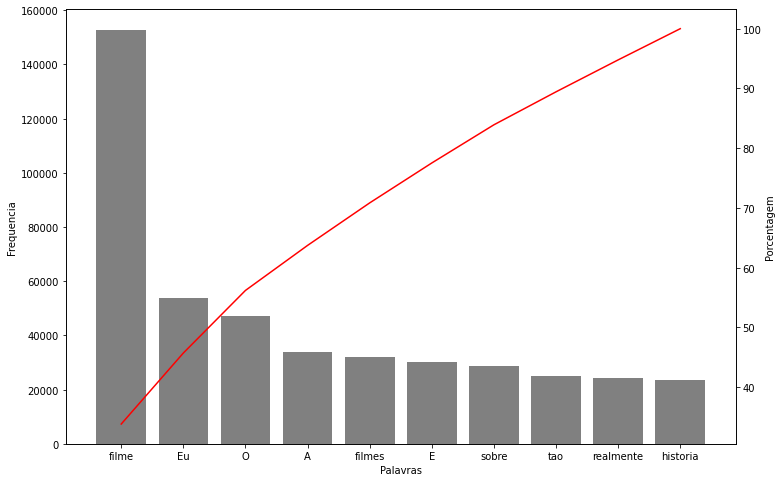

In [ ]:
pareto_real(df, 'tratamento_3', 10)

### Deixando as palavras em minúsculo

In [ ]:
frase_processada = []
for opiniao in df['tratamento_3']:
  nova_frase = []
  opiniao = opiniao.lower()
  palavra_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavra_texto:
    if palavra not in stopwords_sem_acento:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))

df['tratamento_4'] = frase_processada

### RSLPS

Em processamento de linguagem natural, o processo de reduzir os elementos a um radical comum, ou seja, um denominador comum, é chamado de "stemização" - reduzir uma palavra com determinadas variações a um radical comum. No nosso pareto, temos uma ocorrência dessa situação: as palavras "filme" e "filmes", que só se diferenciam em número.

Portanto, vamos melhorar ainda mais os nossos dados tratando esses casos, e faremos isso por meio da biblioteca nltk. Dessa biblioteca, importaremos um algoritmo chamado RSLP, que remove os sufixos das palavras, transformando-as em um único radical comum.

In [ ]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
stemmer = nltk.RSLPStemmer()
frase_processada = []

for opiniao in df['tratamento_4']:
  nova_frase = []
  palavra_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavra_texto:
    if palavra not in stopwords_sem_acento:
      nova_frase.append(stemmer.stem(palavra))
  frase_processada.append(' '.join(nova_frase))

df['tratamento_5'] = frase_processada

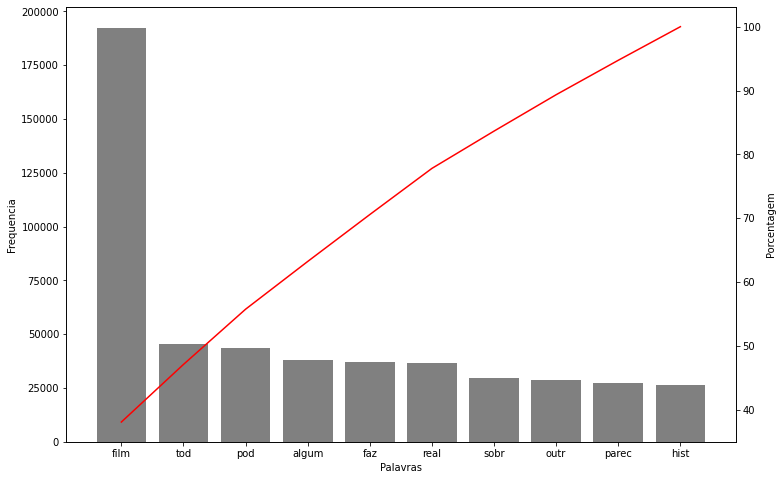

In [ ]:
pareto_real(df, 'tratamento_5', 10)

### TF - IDF

O TF-IDF irá contar a frequência das palavras, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação. Aqui já vamos aplicar o nosso modelo de regressão para ver o quanto melhorou o nosso modelo a partir dessas alterações que fizemos.

In [ ]:
# tfidf = TfidfVectorizer(lowercase=False, max_features=50)

# # aplicando aos nossos dados brutos
# tfidf_bruto = tfidf.fit_transform(df['text_pt'])
# treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto, df['classe'], random_state=42)

# reg_log.fit(treino, classe_treino)
# acc = reg_log.score(teste, classe_teste)
# acc

In [ ]:
tfidf_tratados = tfidf.fit_transform(df['tratamento_5'])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_tratados, df['classe'], random_state=42)

reg_log.fit(treino, classe_treino)
acc = reg_log.score(teste, classe_teste)
acc

0.6963202587949858

Aqui observamos uma melhora de 4%, não é algo tão grande, por isso vamos optar por fazer mais uma alteração no caso vamos usar o Ngrams. Bora lá!!

## Aplicando Ngram

Um modelo de n-grama é um tipo de modelo de linguagem probabilístico para prever o próximo item em tal sequência na forma de um modelo de Markov. Modelos de n-grama são agora amplamente usados em probabilidade, teoria da comunicação, linguística computacional (por exemplo, processamento estatístico de linguagem natural), biologia computacional (por exemplo, análise de sequência biológica) e compressão de dados. Dois benefícios dos modelos de n-grama (e algoritmos que os usam) são simplicidade e escalabilidade - com n maior, um modelo pode armazenar mais contexto com uma compensação espaço-tempo bem compreendida, permitindo que pequenos experimentos sejam escalonados com eficiência.

In [ ]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
vetor_tfidf = tfidf.fit_transform(df["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,
                                                              df["classe"],
                                                              random_state = 42)
reg_log.fit(treino, classe_treino)
acc_tfidf_ngrams = reg_log.score(teste, classe_teste)
print(acc_tfidf_ngrams)

0.8856449656287909


**Algo a se avaliar no ngrams é que ele dobra o valor de dados, então devemos pensar se queremos mesmo usar ele, pois o poder computacional requerido vai ser bem maior.**

In [ ]:
# sem usar o ngrams
tfidf = TfidfVectorizer(lowercase=False)
vetor_tfidf = tfidf.fit_transform(df["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,
                                                              df["classe"],
                                                              random_state = 42)
reg_log.fit(treino, classe_treino)
acc_tfidf_ngrams = reg_log.score(teste, classe_teste)
print(acc_tfidf_ngrams)

0.8847553578649414


Caso queira ver as palavras com maior peso, no caso as palavras que mais influenciaram na hora de classificar algo como negativo ou positivo, pode se usar o seguinte conjunto de código.

In [ ]:
# palavras com maior peso
pesos = pd.DataFrame(
    reg_log.coef_[0].T,
    index = tfidf.get_feature_names()
)

pesos.nlargest(10,0)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0
otim,8.308451
excel,7.993105
perfeit,6.548647
favorit,5.781222
maravilh,5.291919
incri,5.052568
hilari,4.654489
divert,4.552203
ador,4.410095
brilh,4.268983


In [ ]:
# pesos de negativos
pesos.nsmallest(10,0)

,0
pi,-9.184374
ruim,-9.178711
horri,-8.761561
terri,-7.195839
chat,-6.921857
nad,-6.032458
infeliz,-5.298478
decepca,-4.985072
ridicul,-4.971446
parec,-4.938893
